Parsed 9 nodes and 4 quad elements.
Converted to 8 triangular elements.
Assembled global stiffness matrix K (18x18).
Load vector and BCs built. Fixed DOFs: [0, 1, 10, 11, 14, 15]

NODAL DISPLACEMENTS (uy, uz):
Node  1: uy= 0.000000e+00, uz= 0.000000e+00
Node  2: uy= 1.708206e-01, uz=-4.368427e-01
Node  3: uy= 5.213527e-02, uz=-1.933058e-01
Node  4: uy= 3.237391e-02, uz=-1.414926e-01
Node  5: uy= 6.209613e-02, uz=-2.235166e-01
Node  6: uy= 0.000000e+00, uz= 0.000000e+00
Node  7: uy= 4.364034e-03, uz=-1.175151e-01
Node  8: uy= 0.000000e+00, uz= 0.000000e+00
Node  9: uy= 2.197532e-01, uz=-4.527246e-01


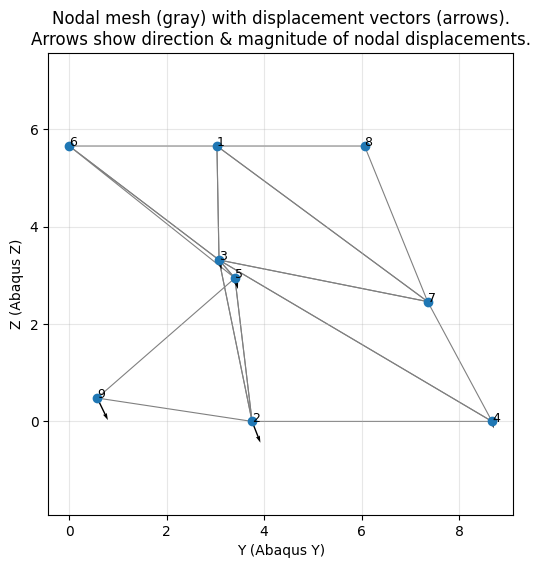

Plot 1: Mesh + quiver. Look at arrow lengths to understand which nodes move more.


ValueError: z array must have same length as triangulation x and y arrays

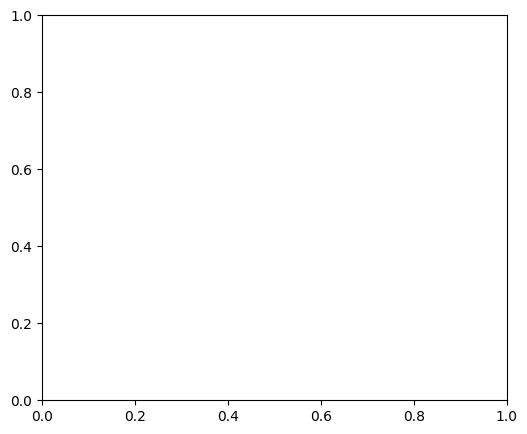

In [2]:
#%%
"""
FEA_on_inp_and_dat_enhanced.py

Enhanced Jupyter-style Python script — adds clear, educational visualizations and explanations
so you can understand the results:

What I improved:
- Added displacement magnitude calculation and a filled contour (via matplotlib.tri) for an easy visual of where
  the model deforms most.
- Added quiver arrows showing nodal displacement vectors on top of the mesh.
- Computed element-wise strains/stresses (plane-stress) and a von Mises stress field, then plotted a colored
  triangular patch plot of von Mises stress (with colorbar) so you can see stress concentrations.
- Added histograms of displacement magnitudes and von Mises stress to summarize results numerically.
- Inserted clear printed explanations at each major step to guide learning.

Notes / Limitations:
- This is still a **membrane** (plane-stress) approximation — no bending/rotational DOFs from S4 shells.
- Results will therefore differ from Abaqus S4 outputs, but the visualizations are useful to learn and compare.

Run cell-by-cell in Jupyter or as a script. Use `scale` to exaggerate displacements for visualization.
"""

#%%
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from math import isclose

# For nicer plots by default (but not forcing a specific color scheme)
plt.rcParams.update({'figure.max_open_warning': 20, 'font.size': 10})

#%%
# ---------------------
# 1) Input (nodes & elements) — same as before
# ---------------------

inp_nodes_text = """
       1,       -94.20163726309161,       3.0303030000000017,                 5.652396
       2,          -94.20163726309161,          3.751702126589781,          0.0
       3,          -94.20163726309161,          3.0733534334008734,          3.31365423269048
       4,          -94.20163726309161,          8.676279168533132,          0.0
       5,          -94.20163726309161,          3.3995865702584034,          2.941934626109802
       6,       -94.20163726309161,   3.1086244689504383E-15,                 5.652396
       7,          -94.20163726309161,          7.354721352535645,          2.4594220322105125
       8,       -94.20163726309161,                 6.060606,                 5.652396
       9,          -94.20163726309161,          0.5728504162228081,          0.480198653935908
"""

inp_elems_text = """
       1,        1,        3,        7,        8
       2,        3,        1,        6,        5
       3,        2,        3,        5,        9
       6,        3,        2,        4,        7
"""

#%%
# 2) Parsing helpers

def parse_nodes(text):
    nodes = {}
    for line in text.strip().splitlines():
        parts = [p.strip() for p in line.split(',') if p.strip()!='']
        if len(parts) >= 4:
            nid = int(parts[0])
            x = float(parts[1]); y = float(parts[2]); z = float(parts[3])
            nodes[nid] = np.array([y, z], dtype=float)  # map to 2D: (Y,Z)
    return nodes


def parse_elems(text):
    elems = {}
    for line in text.strip().splitlines():
        parts = [p.strip() for p in line.split(',') if p.strip()!='']
        if len(parts) >= 5:
            eid = int(parts[0])
            conn = [int(x) for x in parts[1:5]]
            elems[eid] = conn
    return elems

nodes = parse_nodes(inp_nodes_text)
quads = parse_elems(inp_elems_text)

print('Parsed {} nodes and {} quad elements.'.format(len(nodes), len(quads)))

# convert quads -> triangles (consistent pattern)
tri_elems = []
for eid,conn in quads.items():
    n1,n2,n3,n4 = conn
    tri_elems.append((eid*10+1, [n1,n2,n3]))
    tri_elems.append((eid*10+2, [n1,n3,n4]))

print('Converted to {} triangular elements.'.format(len(tri_elems)))

#%%
# 3) Material and element stiffness (same as before) + helper to compute area, B
E = 40000.0
nu = 0.3
thickness = 0.8

C = (E / (1 - nu*nu)) * np.array([[1.0, nu, 0],[nu, 1.0, 0],[0,0,(1-nu)/2]])


def tri_area_and_B(coords):
    x1,y1 = coords[0]
    x2,y2 = coords[1]
    x3,y3 = coords[2]
    A = 0.5 * ((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))
    if abs(A) < 1e-12:
        raise ValueError('Zero area triangle')
    b1 = y2 - y3
    b2 = y3 - y1
    b3 = y1 - y2
    c1 = x3 - x2
    c2 = x1 - x3
    c3 = x2 - x1
    B = (1.0/(2.0*A)) * np.array([
        [b1,   0, b2,   0, b3,   0],
        [0,  c1,  0, c2,  0, c3],
        [c1, b1, c2, b2, c3, b3]
    ])
    return float(abs(A)), B

# assemble global stiffness
node_ids = sorted(nodes.keys())
nid_to_idx = {nid: i for i,nid in enumerate(node_ids)}
ndof = 2 * len(node_ids)
K = np.zeros((ndof, ndof))

# store element-level data for later stress plotting
elem_data = []  # list of dicts: {eid, conn, A, B, ke}

for eid,conn in tri_elems:
    coords = np.array([nodes[n] for n in conn])
    A,B = tri_area_and_B(coords)
    ke = thickness * A * (B.T @ C @ B)
    elem_data.append({'eid':eid, 'conn':conn, 'A':A, 'B':B, 'ke':ke})
    dof_map = []
    for n in conn:
        idx = nid_to_idx[n]
        dof_map += [2*idx, 2*idx+1]
    for i in range(6):
        for j in range(6):
            K[dof_map[i], dof_map[j]] += ke[i,j]

print('Assembled global stiffness matrix K ({}x{}).'.format(ndof, ndof))

#%%
# 4) Loads & BCs (same inference as before)
load_node = 2
load_value = -11998.93671200517
fixed_nodes = [1,6,8]

f = np.zeros(ndof)
f[2*nid_to_idx[load_node] + 1] = load_value  # apply in v-direction (Z)

fixed_dofs = []
for n in fixed_nodes:
    fixed_dofs += [2*nid_to_idx[n], 2*nid_to_idx[n]+1]
free_dofs = [i for i in range(ndof) if i not in fixed_dofs]

print('Load vector and BCs built. Fixed DOFs:', fixed_dofs)

#%%
# 5) Solve
K_ff = K[np.ix_(free_dofs, free_dofs)]
f_f = f[free_dofs]

u = np.zeros(ndof)
try:
    u_free = np.linalg.solve(K_ff, f_f)
except np.linalg.LinAlgError:
    u_free = np.linalg.pinv(K_ff) @ f_f
u[free_dofs] = u_free

# nodal displacements printed nicely
print('\nNODAL DISPLACEMENTS (uy, uz):')
for nid in node_ids:
    idx = nid_to_idx[nid]
    print(f'Node {nid:>2}: uy={u[2*idx]: .6e}, uz={u[2*idx+1]: .6e}')

#%%
# 6) Derived fields: displacement magnitude per node, tri element stresses and von Mises
U_nodes = np.array([ [u[2*i], u[2*i+1]] for i in range(len(node_ids)) ])
disp_mag = np.linalg.norm(U_nodes, axis=1)  # magnitude per node

# element-wise stress
elem_stress_vm = []
for ed in elem_data:
    conn = ed['conn']
    B = ed['B']
    # extract nodal displacements for this element
    u_e = np.zeros(6)
    for i,n in enumerate(conn):
        idx = nid_to_idx[n]
        u_e[2*i] = u[2*idx]
        u_e[2*i+1] = u[2*idx+1]
    strain = B @ u_e  # [exx, eyy, exy]
    stress = C @ strain  # plane stress
    sxx, syy, sxy = stress[0], stress[1], stress[2]
    # von Mises for plane stress
    von = np.sqrt(sxx*sxx - sxx*syy + syy*syy + 3*(sxy**2))
    elem_stress_vm.append(von)

# map element vm to tri indices for plotting
triangles = []
tri_vm = []
for ed,vm in zip(elem_data, elem_stress_vm):
    conn = ed['conn']
    # convert node ids to indices for triangulation
    triangles.append([nid_to_idx[n] for n in conn])
    tri_vm.append(vm)
triangles = np.array(triangles)
tri_vm = np.array(tri_vm)

#%%
# 7) Visualization: multiple clear plots with explanations
scale = 1.0  # tweak to exaggerate deformation in plots
coords_mat = np.array([nodes[n] for n in node_ids])
Ucoords = coords_mat + scale * U_nodes

# 7a) Mesh + quiver (displacement vectors)
plt.figure(figsize=(6,6))
for tri in triangles:
    pts = coords_mat[tri]
    plt.gca().add_patch(plt.Polygon(pts, fill=None, edgecolor='gray', linewidth=0.8))
plt.quiver(coords_mat[:,0], coords_mat[:,1], U_nodes[:,0], U_nodes[:,1], angles='xy', scale_units='xy', scale=1.0, width=0.003)
plt.scatter(coords_mat[:,0], coords_mat[:,1], zorder=3)
for i,nid in enumerate(node_ids):
    plt.text(coords_mat[i,0], coords_mat[i,1], str(nid), fontsize=9, color='black')
plt.title('Nodal mesh (gray) with displacement vectors (arrows).\nArrows show direction & magnitude of nodal displacements.')
plt.xlabel('Y (Abaqus Y)')
plt.ylabel('Z (Abaqus Z)')
plt.axis('equal')
plt.grid(alpha=0.3)
plt.show()

print('Plot 1: Mesh + quiver. Look at arrow lengths to understand which nodes move more.')

# 7b) Filled contour of displacement magnitude using triangulation
triang = mtri.Triangulation(coords_mat[:,0], coords_mat[:,1], triangles)
plt.figure(figsize=(6,5))
plt.tricontourf(triang, np.repeat(disp_mag, 1)[triang.triangles].mean(axis=1), cmap='viridis')
plt.colorbar(label='Displacement magnitude (units)')
plt.tricontour(triang, np.repeat(disp_mag, 1)[triang.triangles].mean(axis=1), colors='k', linewidths=0.5)
plt.title('Filled contour: mean nodal displacement per triangle')
plt.scatter(coords_mat[:,0], coords_mat[:,1], s=10)
plt.axis('equal')
plt.xlabel('Y'); plt.ylabel('Z')
plt.show()
print('Plot 2: Contour of displacement magnitude (helpful to spot high-deformation zones).')

# 7c) Colored element plot of von Mises stress
plt.figure(figsize=(6,5))
collection = plt.tripcolor(coords_mat[:,0], coords_mat[:,1], triangles, tri_vm, shading='flat')
plt.colorbar(collection, label='Von Mises stress (units)')
plt.title('Element-wise Von Mises stress (plane-stress approximation)')
plt.scatter(coords_mat[:,0], coords_mat[:,1], s=8, color='k')
plt.axis('equal')
plt.xlabel('Y'); plt.ylabel('Z')
plt.show()
print('Plot 3: Von Mises stress across elements — shows stress concentration regions. Remember units are consistent with E and applied load.')

# 7d) Histogram of displacement magnitudes
plt.figure(figsize=(6,3))
plt.hist(disp_mag, bins=8)
plt.title('Histogram of nodal displacement magnitudes')
plt.xlabel('Displacement magnitude'); plt.ylabel('Count')
plt.show()

# 7e) Histogram of von Mises stresses
plt.figure(figsize=(6,3))
plt.hist(tri_vm, bins=8)
plt.title('Histogram of element Von Mises stress')
plt.xlabel('Von Mises stress'); plt.ylabel('Count')
plt.show()

# 7f) Deformed vs undeformed overlay (scaled for clarity)
plt.figure(figsize=(6,6))
# undeformed
for tri in triangles:
    pts = coords_mat[tri]
    plt.gca().add_patch(plt.Polygon(pts, fill=None, edgecolor='gray', linewidth=0.7, alpha=0.6))
# deformed
for tri in triangles:
    pts = Ucoords[tri]
    plt.gca().add_patch(plt.Polygon(pts, fill=None, edgecolor='red', linewidth=1.0, alpha=0.9))
plt.scatter(coords_mat[:,0], coords_mat[:,1], label='undeformed', s=8)
plt.scatter(Ucoords[:,0], Ucoords[:,1], label='deformed (scaled)', s=8)
plt.legend()
plt.title('Overlay: undeformed (gray) and deformed (red)')
plt.axis('equal')
plt.xlabel('Y'); plt.ylabel('Z')
plt.show()

print('\nPlot 4: Overlay of undeformed and (scaled) deformed mesh to visually judge total deformation pattern.')

#%%
# 8) Simple numeric summaries and guidance for interpretation
print('\nNUMERIC SUMMARY:')
print('Max nodal displacement magnitude: {:.6e}'.format(np.max(disp_mag)))
print('Min nodal displacement magnitude: {:.6e}'.format(np.min(disp_mag)))
print('Mean nodal displacement magnitude: {:.6e}'.format(np.mean(disp_mag)))
print('\nVon Mises stress (elements): max={:.6e}, mean={:.6e}, min={:.6e}'.format(np.max(tri_vm), np.mean(tri_vm), np.min(tri_vm)))

print('\nINTERPRETATION GUIDE:')
print('- Look at the contour and von Mises plots: similar high-value locations in both indicate structural regions sensitive to the applied load.')
print('- Quiver plot helps you see direction of motion; contour shows magnitude distribution; von Mises shows where stress concentrates.')
print('- Remember: because we used a membrane approximation, high bending-dominated behaviour will not be captured.')

#%%
# 9) Comparison to Abaqus nodal results (as before)
abaqus_dat = {
    2: {'U1':0.0, 'U2':6.3913083E-01, 'U3':-8.0421002E-01},
    3: {'U1':0.0, 'U2':1.2584936E-01, 'U3':-2.9018070E-01},
    4: {'U1':0.0, 'U2':8.2453777E-01, 'U3':9.2126502E-01},
    5: {'U1':0.0, 'U2':1.8547947E-01, 'U3':-3.7633331E-01},
    7: {'U1':0.0, 'U2':6.8571494E-02, 'U3':1.3421406E-01},
    9: {'U1':0.0, 'U2':6.8906124E-01, 'U3':-1.0128338E+00}
}

comparisons = []
for nid,vals in abaqus_dat.items():
    if nid not in nid_to_idx:
        continue
    idx = nid_to_idx[nid]
    uy_sim = u[2*idx]
    uz_sim = u[2*idx+1]
    comparisons.append((nid, vals['U2'], uy_sim, vals['U3'], uz_sim))

print('\nCOMPARISON TO ABAQUS (selected nodes):')
errors = []
for nid, U2_aba, uy_sim, U3_aba, uz_sim in comparisons:
    err_y = abs((uy_sim - U2_aba) / (U2_aba if abs(U2_aba)>1e-12 else 1.0)) if U2_aba!=0 else abs(uy_sim - U2_aba)
    err_z = abs((uz_sim - U3_aba) / (U3_aba if abs(U3_aba)>1e-12 else 1.0)) if U3_aba!=0 else abs(uz_sim - U3_aba)
    errors.append((err_y, err_z))
    print(f"Node {nid}: Abaqus U2={U2_aba:.6e}, sim uy={uy_sim:.6e}, rel_err_y={err_y:.3f}; Abaqus U3={U3_aba:.6e}, sim uz={uz_sim:.6e}, rel_err_z={err_z:.3f}")

flat_errs = [e for pair in errors for e in pair]
mean_rel_err = float(np.mean(flat_errs))
print(f"\nMean relative error (across compared DOFs): {mean_rel_err:.3f}")

# Final note reminder for the learner
print('\nFINAL NOTE: This enhanced visualization pipeline is for learning and verification. If you want closer agreement to Abaqus S4 shell results,\nI can either: (A) implement a shell (S4-like) element with rotational DOFs, or (B) extract and compare in-plane membrane components only.\nWhich approach would you like next?')
